In [ ]:
!pip install pytorch_lightning
!pip install transformers
!pip install torchmetrics

In [110]:

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from torchmetrics.functional import auroc, accuracy, f1
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [135]:
df = pd.read_csv('train_intents.csv' )
df = df.drop(columns=['Unnamed: 0','find_bus'], errors='ignore')
LABEL_COLUMNS = [ 'book_hotel', 'book_restaurant', 'book_train', 'find_attraction', 'find_hospital', 'find_hotel', 'find_police', 'find_restaurant', 'find_taxi', 'find_train', 'no_intent']
df

,Unnamed: 0.1,text,intents,book_hotel,book_restaurant,book_train,find_attraction,find_hospital,find_hotel,find_police,find_restaurant,find_taxi,find_train,no_intent
0,0,i need a place to dine in the center thats exp...,"['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
1,1,"Any sort of food would be fine, as long as it ...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
2,2,"Sounds good, could I get that phone number? Al...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
3,3,Yes. Can you book it for me?,['find_hotel'],0,0,0,0,0,1,0,0,0,0,0
4,4,i want to book it for 2 people and 2 nights st...,['book_hotel'],1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50833,51239,what is there phone number?,['find_restaurant'],0,0,0,0,0,0,0,1,0,0,0
50834,51240,"no, thank you. Goodbye.",['no_intent'],0,0,0,0,0,0,0,0,0,0,1
50835,51241,"Hello, I am looking for a cheap restaurant tha...",['find_restaurant'],0,0,0,0,0,0,0,1,0,0,0
50836,51242,"Yes, how about portuguese food?",['find_restaurant'],0,0,0,0,0,0,0,1,0,0,0


['book_hotel', 'book_restaurant', 'book_train', 'find_attraction', 'find_hospital', 'find_hotel', 'find_police', 'find_restaurant', 'find_taxi', 'find_train', 'no_intent']


In [113]:
val_df = pd.read_csv('test_intents.csv' )
val_df = val_df.drop(columns=['Unnamed: 0','find_bus'], errors='ignore')

val_df

,Unnamed: 0.1,text,intents,book_hotel,book_restaurant,book_train,find_attraction,find_hospital,find_hotel,find_police,find_restaurant,find_taxi,find_train,no_intent
0,0,i need a place to dine in the center thats exp...,"['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
1,1,"Any sort of food would be fine, as long as it ...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
2,2,"Sounds good, could I get that phone number? Al...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
3,3,Yes. Can you book it for me?,['find_hotel'],0,0,0,0,0,1,0,0,0,0,0
4,4,i want to book it for 2 people and 2 nights st...,['book_hotel'],1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6797,6838,I would like to visit a cinema of the west side.,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0
6798,6839,How about a museum then?,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0
6799,6840,I would prefer a museum. One with free entry i...,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0
6800,6841,That is fine. Book me a ticket and get me a re...,['find_attraction'],0,0,0,1,0,0,0,0,0,0,0


In [138]:
df1 = df.copy()

intentdf = []
for intent in LABEL_COLUMNS:
  intent_sample_df = df1[  (df1[LABEL_COLUMNS].sum(axis=1) == 1) & (df1[intent] == 1)]
  intent_sample_df = intent_sample_df.sample(2000, replace=True)
  intentdf.append( intent_sample_df)

multiple_intent_df = df1[df1[LABEL_COLUMNS].sum(axis=1) > 1]  
train_df = pd.concat([multiple_intent_df, *intentdf])

train_df

,Unnamed: 0.1,text,intents,book_hotel,book_restaurant,book_train,find_attraction,find_hospital,find_hotel,find_police,find_restaurant,find_taxi,find_train,no_intent
0,0,i need a place to dine in the center thats exp...,"['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
1,1,"Any sort of food would be fine, as long as it ...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
2,2,"Sounds good, could I get that phone number? Al...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
7,7,"No, but I'd really like to be on the south end...","['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
8,8,No I don't care about the price. Which one do ...,"['find_restaurant', 'find_hotel']",0,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48377,48762,"Awesome, thanks a lot. That's all I needed today.",['no_intent'],0,0,0,0,0,0,0,0,0,0,1
24413,24650,Wonderful! That is all I needed. Thank you so ...,['no_intent'],0,0,0,0,0,0,0,0,0,0,1
985,1004,No that is all I do believe thanks for all of ...,['no_intent'],0,0,0,0,0,0,0,0,0,0,1
44272,44637,thanks for your time and services,['no_intent'],0,0,0,0,0,0,0,0,0,0,1


In [139]:
train_df.shape, val_df.shape

((28690, 14), (6802, 14))

In [ ]:
#train_df = train_df.sample(5000)

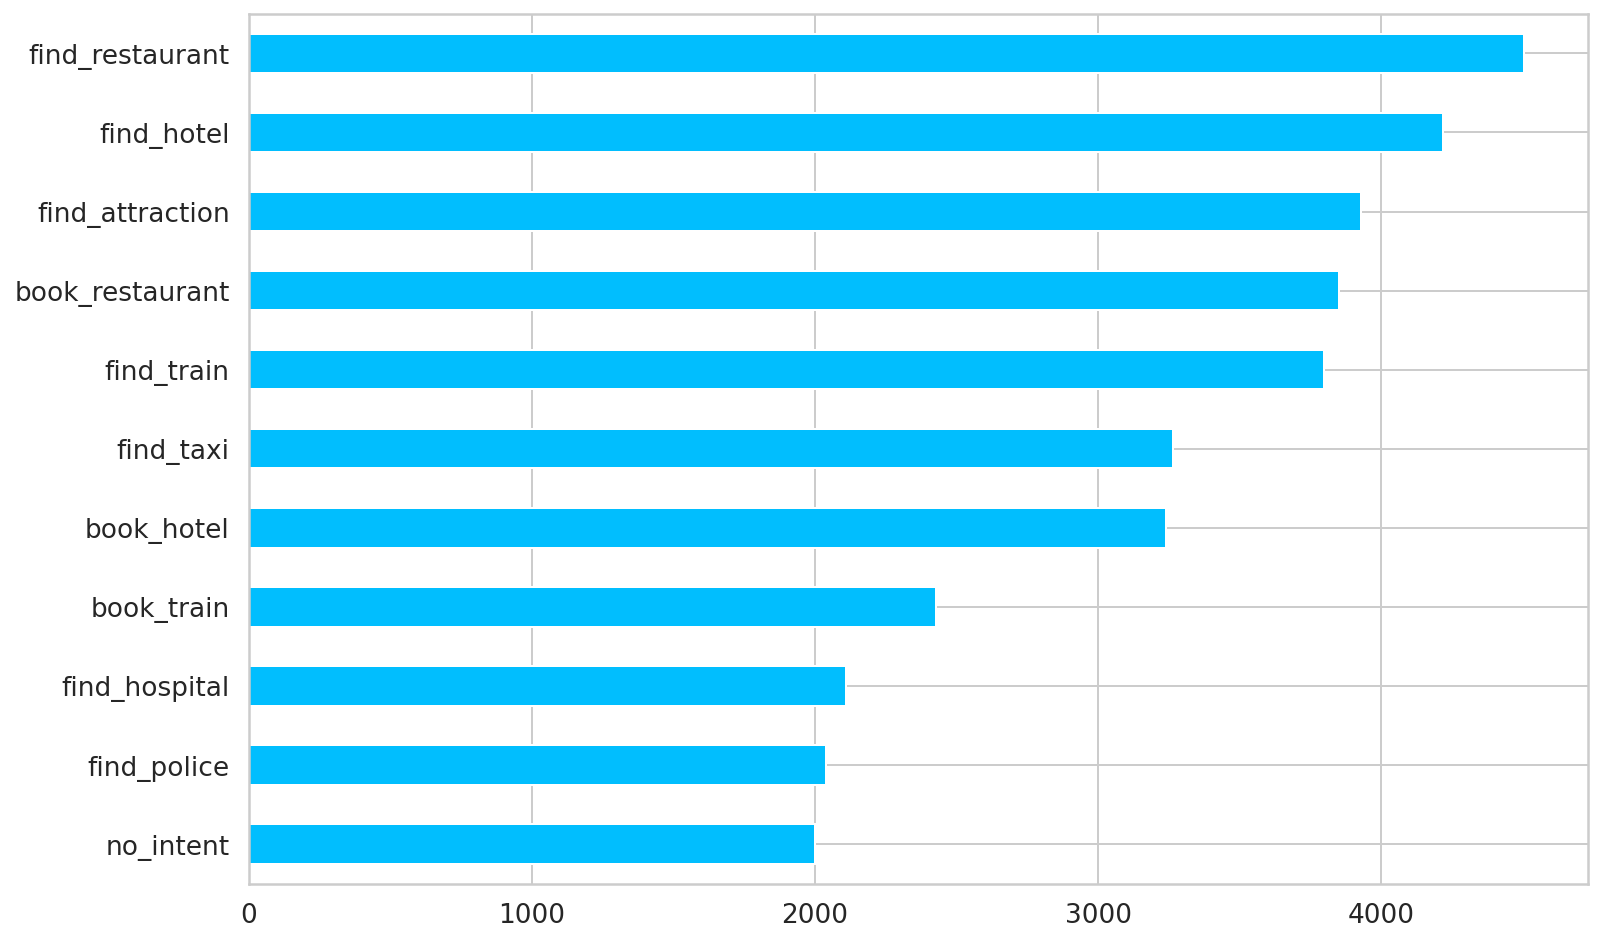

In [140]:

train_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [141]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [142]:
class MultiWOZIntentDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)
  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    text = data_row.text
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [143]:
train_dataset = MultiWOZIntentDataset(train_df, tokenizer)

In [144]:
class MultiWOZIntentDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len
  def setup(self, stage=None):
    self.train_dataset = MultiWOZIntentDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )
    self.test_dataset = MultiWOZIntentDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )
  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [145]:
N_EPOCHS = 2
BATCH_SIZE = 12
MAX_TOKEN_COUNT  = 128
data_module = MultiWOZIntentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)
data_module.setup()

# Model

In [147]:
class IntentClassifier(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()
     
  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output
  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [148]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(956, 4780)

In [149]:
model = IntentClassifier(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [150]:

checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)


logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
  logger=logger,
  callbacks=[checkpoint_callback, early_stopping_callback],
  max_epochs=1,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 8.5 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.275   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

In [ ]:
trainer.test()

MisconfigurationException: ignored

In [ ]:
trained_model = IntentClassifier.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

# Predictions

In [ ]:
test_text = "No I don't care about the price. Which one do you recommend?"
encoding = tokenizer.encode_plus(
  test_text,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

In [ ]:
THRESHOLD = 0.5
test_comment = "i need a place to dine in the center thats expensive"
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)
_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

# Evaluation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
val_dataset = MultiWOZIntentDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))